In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
col_list=["date","new_deaths"]
dataset = pd.read_csv("new deaths dataset.csv",usecols=col_list,index_col='date', parse_dates=True)
print('shape',dataset.shape)
dataset.describe()

shape (500, 1)


,new_deaths
count,500.000000
mean,1.646000
std,3.354876
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,28.000000


<AxesSubplot:xlabel='date'>

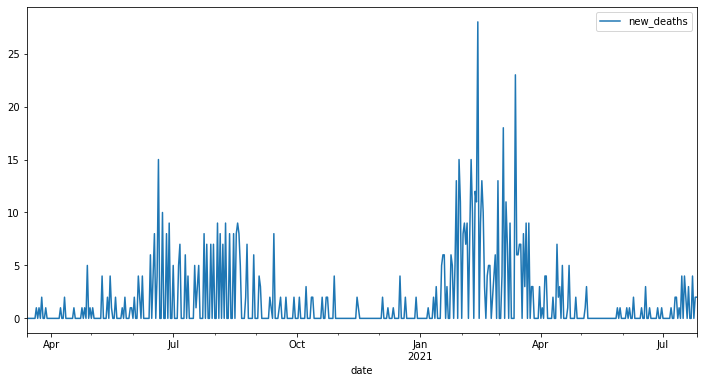

In [3]:
df=dataset
df.plot(figsize=(12,6))

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

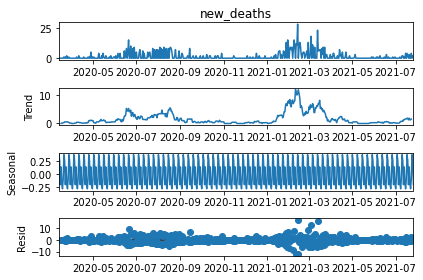

In [5]:
results = seasonal_decompose(df['new_deaths'])
results.plot();

In [6]:
train= df.iloc[:450]
test= df.iloc[450:]

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [8]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [9]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [10]:
# define generator
n_input = 9
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [12]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [14]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
441/441 [==============================] - 1s 3ms/step - loss: 0.0639
Epoch 2/50
441/441 [==============================] - 1s 3ms/step - loss: 0.0636
Epoch 3/50
441/441 [==============================] - 1s 3ms/step - loss: 0.0630
Epoch 4/50
441/441 [==============================] - 1s 3ms/step - loss: 0.0623
Epoch 5/50
441/441 [==============================] - 1s 3ms/step - loss: 0.0624
Epoch 6/50
441/441 [==============================] - 1s 3ms/step - loss: 0.0624
Epoch 7/50
441/441 [==============================] - 1s 3ms/step - loss: 0.0641
Epoch 8/50
441/441 [==============================] - 1s 3ms/step - loss: 0.0616
Epoch 9/50
441/441 [==============================] - 1s 3ms/step - loss: 0.0619
Epoch 10/50
441/441 [==============================] - 1s 3ms/step - loss: 0.0620
Epoch 11/50
441/441 [==============================] - 1s 3ms/step - loss: 0.0615
Epoch 12/50
441/441 [==============================] - 1s 3ms/step - loss: 0.0598
Epoch 13/50
441/441 [====

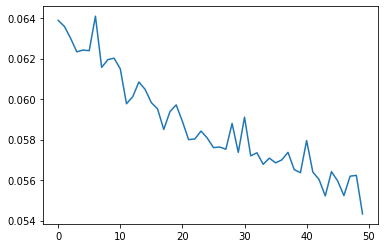

In [15]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [16]:
last_train_batch = scaled_train[-9:]

In [17]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [18]:
model.predict(last_train_batch)

array([[0.00012281]], dtype=float32)

In [19]:
scaled_test[0]

array([0.])

In [20]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [21]:
test_predictions

[array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 

In [22]:
true_predictions = scaler.inverse_transform(test_predictions)

In [23]:
test['Predictions'] = true_predictions

<ipython-input-23-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='date'>

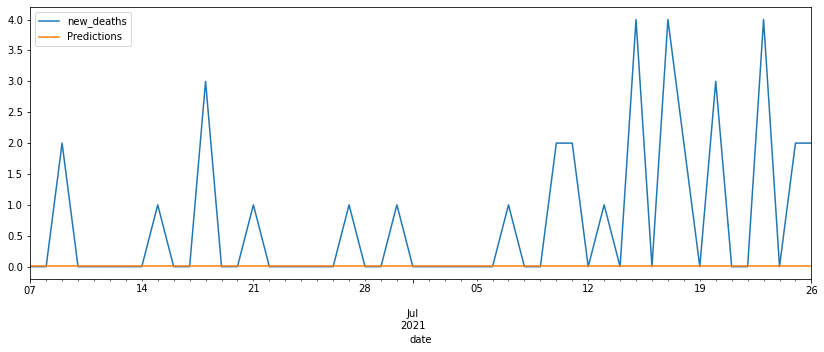

In [24]:
test.plot(figsize=(14,5))

In [25]:
from sklearn.metrics import mean_absolute_error
mae_new_deaths=mean_absolute_error(test['new_deaths'],test['Predictions'])
print('Mean absolute error of new deaths is:',mae_new_deaths)

Mean absolute error of new deaths is: 0.721100351922214


In [26]:
import math 
from statistics import mean
mean_new_deaths = mean(test['new_deaths'])
print(mean_new_deaths)

0.72


In [27]:
test_predictions2 = []

first_eval_batch2 = scaled_train[-n_input:]
current_batch2 = first_eval_batch2.reshape((1, n_input, n_features))

for i in range(400):
    
    # get the prediction value for the first batch
    current_pred2 = model.predict(current_batch2)[0]
    
    # append the prediction into the array
    test_predictions2.append(current_pred2) 
    
    # use the prediction to update the batch and remove the first value
    current_batch2 = np.append(current_batch[:,1:,:],[[current_pred2]],axis=1)

In [28]:
test_predictions2

[array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 array([0.00012281], dtype=float32),
 

In [29]:
true_predictions2 = scaler.inverse_transform(test_predictions2)

In [30]:
idx = pd.date_range("2021-06-07", periods=400 , freq="D")
Predictionss=pd.DataFrame(true_predictions2, index=idx)

In [31]:
Predictionss=Predictionss.round()
Predictionss

,0
2021-06-07,0.0
2021-06-08,0.0
2021-06-09,0.0
2021-06-10,0.0
2021-06-11,0.0
...,...
2022-07-07,0.0
2022-07-08,0.0
2022-07-09,0.0
2022-07-10,0.0


In [32]:
Predictionss.columns=['new_deaths_predicted']

In [33]:
inApril2022= Predictionss.loc['2022-04-01':'2022-04-01']

In [34]:
inApril2022

,new_deaths_predicted
2022-04-01,0.0


In [37]:
tilljuly11 = pd.DataFrame(Predictionss)
tilljuly11

,new_deaths_predicted
2021-06-07,0.0
2021-06-08,0.0
2021-06-09,0.0
2021-06-10,0.0
2021-06-11,0.0
...,...
2022-07-07,0.0
2022-07-08,0.0
2022-07-09,0.0
2022-07-10,0.0


In [38]:
def forecastforthatday(a,b):
    return tilljuly11.loc[a:b]

In [39]:
DD= input("ENTER A DAY ('YYYY-MM-DD'):")

ENTER A DAY ('YYYY-MM-DD'):'2022-04-01'


In [41]:
MM= DD
print("The number of new deaths on", DD ,"were:",forecastforthatday(DD,MM) )

The number of new deaths on '2022-04-01' were:             new_deaths_predicted
2022-04-01                   0.0
